In [30]:
import pandas as pd
from scipy.optimize import root_scalar
import numpy as np
import glob
from matplotlib import pyplot as plt

In [31]:
def gf_kappa(gf, D_d, k, RH):
    A = 4*0.072*0.0180153/(8.3144598*(273.15+20)*1000) #2.28454e-09 # constant 4*0.072*0.0180153/(8.3144598*273.15*1000)
    return (gf**3 - 1) / (gf**3 - (1 - k)) - RH / np.exp(A/(D_d*gf))

def get_root(D_d, k, RH):
    return root_scalar(gf_kappa, args=(D_d, k, RH), bracket=[1, 3], method='brentq').root

In [32]:
ams = pd.read_csv('../exported/AMS.csv', parse_dates=['Time_Start', 'Time_Stop', 'Time_Mid'])

In [33]:
ams['non_org'] = ams[['SO4_Ave_IsoK_STP', 'NO3_Ave_IsoK_STP', 'NH4_Ave_IsoK_STP',
       'Chl_Ave_IsoK_STP']].sum(axis=1)

In [34]:
ams = ams[(ams['non_org'] > 0) & (ams['Org_Ave_IsoK_STP']>0)].reset_index(drop=True)

In [35]:
ams['tot'] = ams['non_org'] + ams['Org_Ave_IsoK_STP']

In [36]:
ams['k'] = ams['Org_Ave_IsoK_STP'] / ams['tot'] * .1 + ams['non_org'] / ams['tot'] * 0.63

In [37]:
version = 'v4.9'
retrieval_paths = sorted(glob.glob('../data/'+ version +'/*/*/*.csv'))
retrieval_list = []
for i in range(0, len(retrieval_paths)):
    retrieval_list.append(pd.read_csv(retrieval_paths[i], parse_dates=['Start_Date_Time_UTC', 'Stop_Date_Time_UTC']))
r = pd.concat(retrieval_list).reset_index(drop=True)

In [38]:
for i in range(0, len(ams)):
    row = ams.iloc[i]
    ams.loc[i,'gf_200'] = get_root(200E-9, row['k'], .85)
    ams.loc[i,'gf_600'] = get_root(600E-9, row['k'], .85)

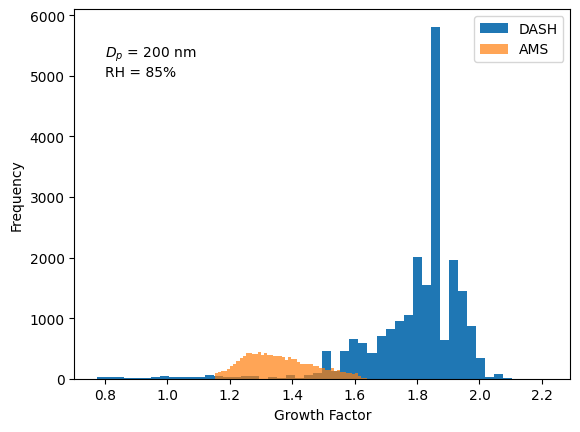

In [39]:
r_sub = r[(r['SEMS_Dp']==200) & (abs(r['RH']-85)<5)]
r_sub['GF_raw'].hist(bins=50, label='DASH')
ams['gf_200'].hist(bins=50, alpha=.7, label='AMS')
plt.xlabel('Growth Factor')
plt.ylabel('Frequency')
plt.annotate('$D_p$ = 200 nm\nRH = 85%', xy=(.8, 5000), xytext=(.8, 5000))
plt.grid(False)
plt.legend()
plt.savefig('../figures/gf_hist_200.png')

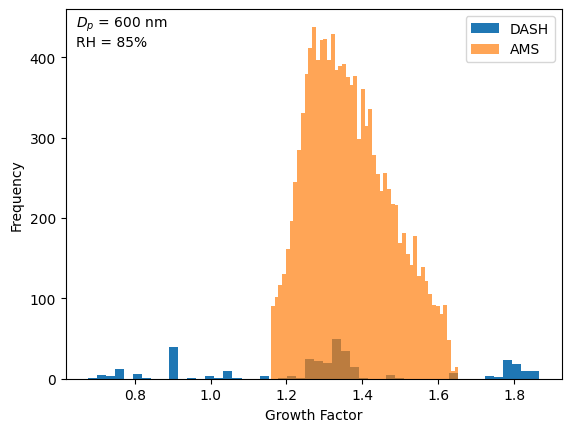

In [46]:
r_sub = r[(r['SEMS_Dp']==600) & (abs(r['RH']-85)<5)]
r_sub['GF_raw'].hist(bins=50, label='DASH')
ams['gf_600'].hist(bins=50, alpha=.7, label='AMS')
plt.xlabel('Growth Factor')
plt.ylabel('Frequency')
plt.annotate('$D_p$ = 600 nm\nRH = 85%', 
             xy=(.02, .90), xycoords='axes fraction')  # Position in axes fraction (top-left corner)
plt.grid(False)
plt.legend()
plt.savefig('../figures/gf_hist_600.png')